In [1]:
import os
os.environ['FSLOUTPUTTYPE'] = 'NIFTI_GZ'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from pathlib import Path
import matplotlib
import seaborn as sns

import matplotlib.pyplot as plt
import nibabel as nib
import matplotlib.cm as cm
import numpy as np
import json
import sys
import time
from tqdm import tqdm

from utils.patch_ops import *

import tensorflow as tf
from models.phinet import *

import cv2

In [2]:
tick_size = 20
sns.set(rc={
    'figure.figsize':(10,10), 
    'font.size': 25, 
    "axes.labelsize":25, 
    "xtick.labelsize": tick_size, 
    "ytick.labelsize": tick_size,
    'font.family':'serif',
    'grid.linestyle': '',
    'axes.facecolor': 'white',
    'axes.edgecolor': '0.2',
    'axes.spines.bottom': True,
    'axes.spines.left': True,
    'axes.spines.right': True,
    'axes.spines.top': True,
})

palette = sns.color_palette("Set2", n_colors=6, desat=1)

In [3]:
int_to_class = {i: c for i, c in enumerate(sorted(['FL', 'FLC', 'PD', 'T1', 'T1C', 'T2']))}

class_to_int = {v:k for k,v in int_to_class.items()}

def running_average(old_average, cur_val, n):
    return old_average * (n-1)/n + cur_val/n


def prepare_data(x_filename, target_dims, class_to_int):
    x = nib.load(x_filename).get_fdata()
    x_slices = get_axial_slices(x, target_dims)

    y = tf.one_hot(
        class_to_int[x_filename.parts[-2]],
        depth=len(class_to_int),
    )

    return x_slices, y

def get_axial_slices(img_vol, target_size):
    return np.array(
        [pad_crop_image_2D(sl, target_size) for sl in np.moveaxis(img_vol, 2, 0)],
        dtype=np.float32,
    )[..., np.newaxis]

In [4]:
########## HYPERPARAMETER SETUP ##########

instance_size = (256, 256)
num_classes = 6
progbar_length = 40

fname = Path('data/preprocess/T1/1030_2a_MR_T1.nii.gz')
GPUID = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = GPUID

In [5]:
########## MODEL SETUP ##########

MODEL_NAME = "phinet"
WEIGHT_DIR = Path("models/weights") / MODEL_NAME
MODEL_PATH = WEIGHT_DIR / (MODEL_NAME + ".json")

with open(MODEL_PATH, 'r') as json_data:
    model = tf.keras.models.model_from_json(json.load(json_data))

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 1 800         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, None, None, 1 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 1 2320        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [7]:
########## GRAD CAM ##########
img_slices, y = prepare_data(fname, instance_size, class_to_int)

In [8]:
LAYER_NAME = 'concatenate'

In [9]:
img_slices.shape

(160, 256, 256, 1)

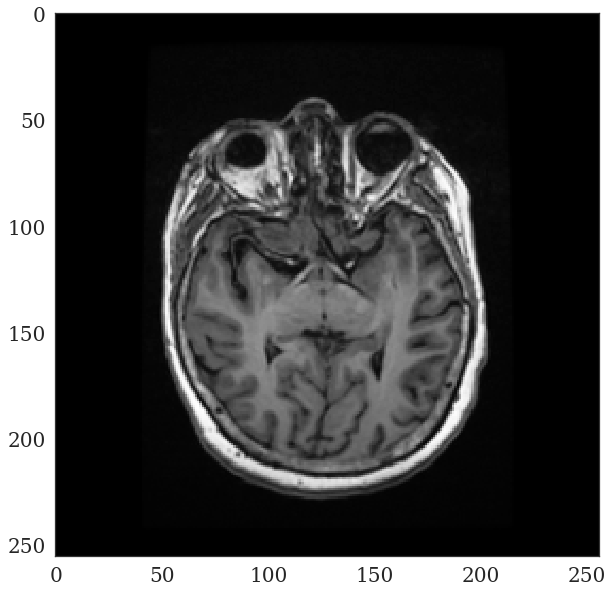

In [18]:
plt.imshow(img_slices[80, :, :, 0].T, cmap='Greys_r')

In [11]:
grad_model = tf.keras.models.Model(
    [model.inputs], 
    [model.get_layer(LAYER_NAME).output, model.output],
)

In [177]:
int_to_class

{0: 'FL', 1: 'FLC', 2: 'PD', 3: 'T1', 4: 'T1C', 5: 'T2'}

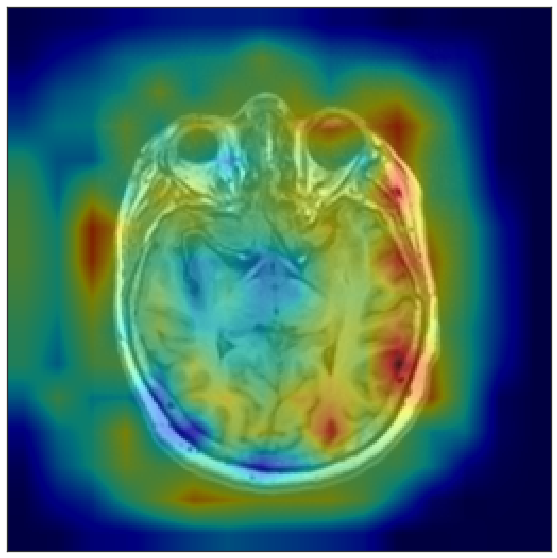

In [191]:
with tf.GradientTape() as tape:
    conv_outputs, logits = grad_model(img_slices[80:81])
    logits = logits[:, 4]
    

preds = tf.nn.softmax(logits)
grads = tape.gradient(
    logits, 
    conv_outputs,
)

c = conv_outputs
pooled_grads = tf.reduce_mean(grads, axis=(1, 2))

i = 0#80

t = tf.reduce_mean(c[i] * pooled_grads[i], axis=-1)
t = np.array(tf.nn.relu(t))
t = (t - t.min()) / (t.max() - t.min())

t = cv2.resize(t, (256, 256), interpolation=cv2.INTER_LINEAR)
plt.imshow(img_slices[80, :, :, 0].T, cmap='Greys_r')
plt.imshow(t.T, cmap='jet', alpha=0.5)
plt.xticks([])
plt.yticks([])
plt.show()

# for i in range(c.shape[0]):
#     if img_slices[i].sum() != 0:
#         t = tf.reduce_mean(c[i] * pooled_grads[i], axis=-1)
#         t = np.array(tf.nn.relu(t))
#         t = (t - t.min()) / (t.max() - t.min())

#         t = cv2.resize(t, (256, 256), interpolation=cv2.INTER_LINEAR)
#         plt.imshow(img_slices[i, :, :, 0].T, cmap='Greys_r')
#         plt.imshow(t.T, cmap='jet', alpha=0.5)
#         plt.xticks([])
#         plt.yticks([])
#         plt.show()
#         break

In [33]:
for slice_num, img_slice in enumerate(img_slices):
    ensemble_cam = np.ones((256, 256), dtype = np.float32)

    for LAYER_NAME in LAYER_NAMES:
        grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(img_slice[np.newaxis, ...])

        output = conv_outputs[0]
        grads = tape.gradient(predictions, conv_outputs)[0]

        gate_f = tf.cast(output > 0, 'float32')
        gate_r = tf.cast(grads > 0, 'float32')
        guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

        weights = tf.reduce_mean(guided_grads, axis=(0, 1))

        cam = np.ones(output.shape[0: 2], dtype = np.float32)

        for i, w in enumerate(weights):
            cam += w * output[:, :, i]

        cam = cv2.resize(cam.numpy(), (256, 256), interpolation=cv2.INTER_LINEAR)
        heatmap = (cam - cam.min()) / (cam.max() - cam.min())

        ensemble_cam += cam
        
    plt.imshow(test_slice[0, :, :, 0].T, cmap='Greys_r')
    plt.imshow(np.moveaxis(ensemble_cam, 0, 1), cmap='jet', alpha=0.3)
    
    output_filename = DST_DIR / "slice_{:003d}_overlay.jpg".format(slice_num)
    plt.savefig(output_filename)

NameError: name 'test_slice' is not defined